## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [15]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/

sys.path.append('../')
from lib.plot_utils import *

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/


### Data paths

In [16]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
brainmaps_dir = results_dir + 'brainmaps/'
demograph_file = 'ABIDE_Phenotype.csv'
sm_perf_file = 'pipelines_sm_perf_DX_GROUP_QC_gleb_N_194.pkl'#'atlas_sm_perf_DX_GROUP_QC_None_N_1047.pkl'

### Global Vars

In [17]:
subject_ID_col = 'SubjID'
subjects_dir = '/home/nikhil/projects/CT_reproduce/data/fs_test_dir/'
subject_id = "fsaverage"

### Load data

In [18]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# # Results
# atlas or pipelines
results_type = 'pipeline' # atlas

if results_type == 'pipeline':
    stat_perf = pd.read_pickle(results_dir + sm_perf_file)
        
else:
    with open(results_dir + sm_perf_file, 'rb') as handle:
        stat_perf = pickle.load(handle)

### Statistical plots 

Plots based on 194 subjects
Top 5 most significant regions                        roi     t_val     p_val  p_val_corr pipeline
33    R_posteriorcingulate -3.399830  0.000674    0.041805     fs51
49  R_lateralorbitofrontal -2.871061  0.004091    0.126820     fs51
4   L_lateralorbitofrontal -2.365777  0.017992    0.185920     fs51
23   R_medialorbitofrontal -2.610155  0.009050    0.185920     fs51
29   L_medialorbitofrontal -2.448506  0.014345    0.185920     fs51


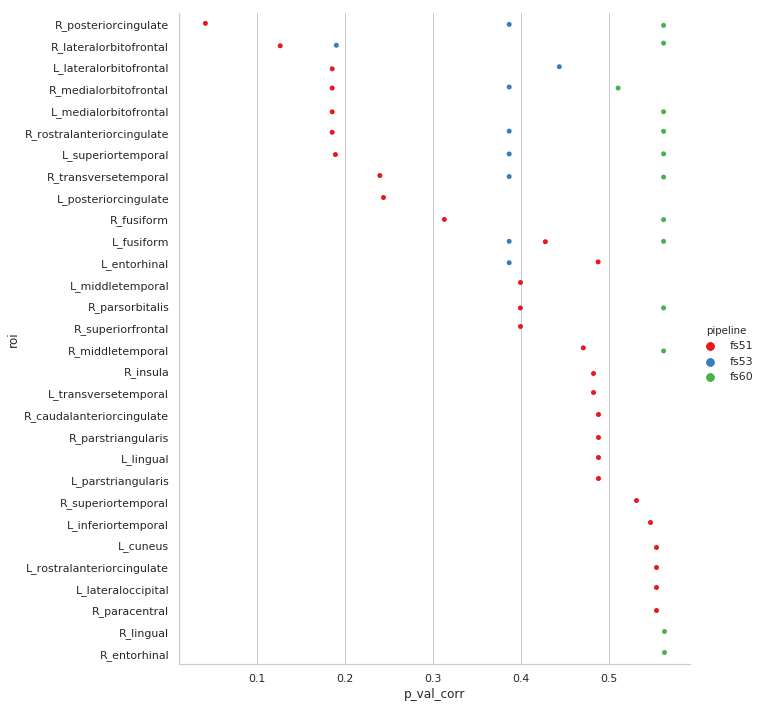

In [19]:
aparc = 'Glasser' #aparc #Destrieux #Glasser
stat_measure = 'p_val_corr'
top_rois = 50
subx = sm_perf_file.rsplit('_',1)[1].split('.',1)[0]
print('Plots based on {} subjects'.format(subx))

if results_type == 'pipeline':
    plot_df = stat_perf.sort_values(by=[stat_measure]).head(top_rois)
    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',hue='pipeline',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");

else:
    plot_df = stat_perf[aparc].sort_values(by=['p_val']).head(top_rois)

    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");
        
print('Top 5 most significant regions {}'.format(plot_df.head(5)))

## PySurfer plots

In [20]:
save_dir = brainmaps_dir + sm_perf_file.split('.',1)[0] + '/'
p_thresh = 0.05

if results_type == 'pipeline':
    pipes = ['fs51','fs53','fs60','civet','ants']
    aparcs = ['aparc']
else:
    pipes = ['fs60']
    aparcs = ['aparc', 'Destrieux', 'Glasser']

for pipe in pipes:
    for aparc in aparcs:
        if results_type == 'pipeline':
            stat_df = stat_perf[stat_perf['pipeline']==pipe]
        else:
            stat_df = stat_perf[aparc]

        signific_rois = stat_df[stat_df[stat_measure] < p_thresh]['roi'].values
        print('Number of signficant ROIs {}'.format(len(signific_rois)))

        plot_regions_L,plot_regions_R = get_pysurfer_label_format(signific_rois,aparc)
        print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))


        # Pysurfer parameters
        surf = 'inflated' #'white' #"inflated"
        views = ['lateral','medial']
        
        if aparc == 'Glasser':
            aparc_file = '.HCP-MMP1.annot' 
        elif aparc == 'Destrieux':
            aparc_file = '.aparc.a2009s.annot' 
        elif aparc in ['aparc', 'DKT']:
            aparc_file = '.aparc.annot'
        else:
            aparc_file = ''
            print('Unknown cortical parcellation')

        for hemi in ['lh','rh']:
            if hemi=='lh':
                signific_rois = plot_regions_L
            elif hemi=='rh':
                signific_rois = plot_regions_R
            else: 
                print('Unknown hemisphere parameter')

            for view in views:
                title = '_{}_{}_{}_{}_{}_{}_N_{}'.format(pipe,aparc,surf,hemi,view,stat_measure,subx)
                brain_fig = create_surface_plot(subject_id,hemi,surf,aparc_file,signific_rois,save_dir,title,view)
                time.sleep(5) #Mayavi messes up if called to quickly

Number of signficant ROIs 1
plot regions 
left: [], 
right: ['posteriorcingulate']
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/pipelines_sm_perf_DX_GROUP_QC_gleb_N_194/surf_fs51_aparc_inflated_lh_lateral_p_val_corr_N_194.png
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/pipelines_sm_perf_DX_GROUP_QC_gleb_N_194/surf_fs51_aparc_inflated_lh_medial_p_val_corr_N_194.png
number of total vertices 163842 and ROIs 36
number of significant rois 1
atlas: .aparc.annot, signficant roi count: {0.0: 146932, 2.0: 2994, -1.0: 13916}
colormap sequential: [-1.00e+00, 5.00e-01, 2.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/pipelines_sm_perf_DX_GROUP_QC_gleb_N_194/surf_fs51_aparc_inflated_rh_lateral_p_val_corr_N_194.png
number of total vertices 163842 and ROIs 36
number of significant rois 1
atlas: .aparc.annot, signficant roi count: {

### Create plot montage

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/pipelines_sm_perf_DX_GROUP_QC_gleb_N_194/
Found 20 images


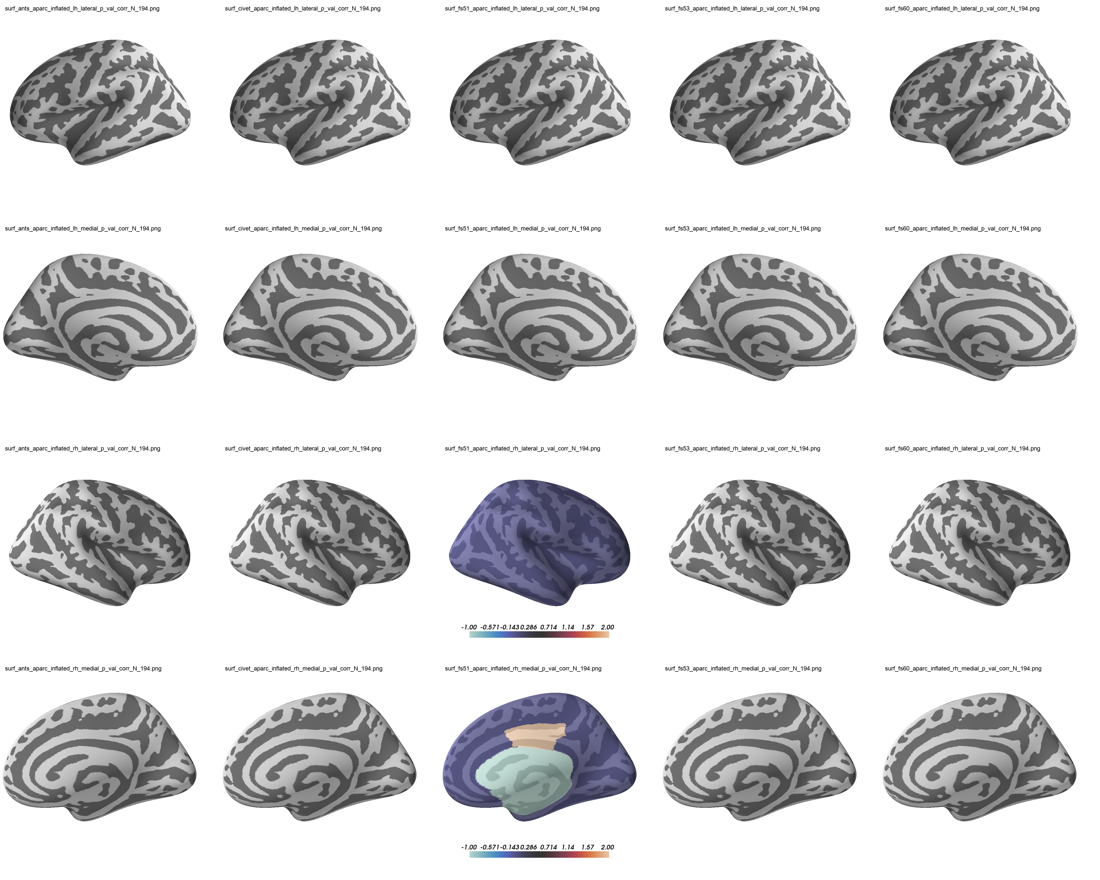

In [21]:
montage_im = createImageMontage(save_dir)
montage_im